### Neural Nets From Scratch

This notebook represents my notes on implementation of feed forward neural network and the back propagation algorithm. I followed The guide at http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

### The Data
We will use one of SciKit Learns data sets for this example. 

In [2]:
np.random.seed(0) # Setting seed ofr consistent example.

nExamples = 200 # Number of training examples

X, y = make_moons(nExamples, noise=0.25)

This data contains 200 exaples with two features, so $X\in\mathbb{R}^{200\times 2}$. The output `y` has two possible classes, so we only need one values to indicate which class it is in, thus $y\in \mathbb{R}^{200}$. We plot the data below and we can see that this data is _not_ linearly seperable, so we need something more complex than a linear method like regression. 

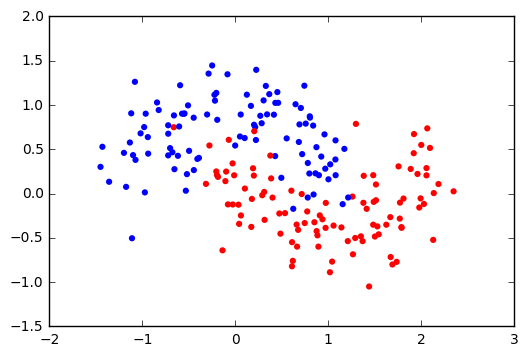

In [3]:
plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=plt.cm.bwr, lw=0)
plt.show()

### The Design of the Neural Net
We will create a neural network with 3 layers: one input, one hidden and one output laters. Since there are two classes (shown as red and blue in the plot above) we will need two output nodes. The `X` variable is made up of two columsn of data, i.e. two variables, so we will also have two imput nodes. 

For the hidden layers, we need to choose the number of nodes and the activation function. In this example, I'm going to use the hyperbolic tangent function $\tanh(x)$. We can also use a sigmoid function $\sigma(x) = 1/(1+e^{-x})$ but it is easier to train the neural net using $\tanh$ since it is a "steaper" function which is helpful when using gradient decent. Another useful fact about hyperbolic tangent is that its derivative is simple:

$$
   {d\over dx}\tanh(x) = 1 + \tanh^2(x)
$$
We can define this activation function now.

In [4]:
activation = lambda x: np.tanh(x)
D_activation = lambda x: 1 - np.power(np.tanh(x),2)

We also want out outputs to represent probabilities, so we want to use a softmax function given by

$$
   \mathrm{softmax} (x) = \frac{e^{x_j}}{\sum_{k=1}^K e^{x_k}} 
$$

where $x_i$ is the $i^{th}$ entry of the vector $x$. Applying the softmax gaurantees that the outputs sum to one and each individual output is bounded by 0 and 1, just like probabilities. 

In [5]:
softmax = lambda x: np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)

To get a prediction for an input $x$, we apply an affine transformation defined by $W_1$, and bias $b_1$ as $z_1 = W_1^T x + b_1$. Then we apply the activation function, $a_1 = \tanh(x)$ and we apply an affine transfrmation to $a_1$ defined by the weights $W_2$ and bias $b_2$ as $z_2 = W_2^T x + b_2$. Next, we apply the softmax function $\mathrm{softmax}(z_2)$. Finally, to make a prediction, we just choose the class that has the largest probability.

We can now code a prediction function up.

In [6]:
def predict(model, x):
    """Gives a prediction of the class the value x belongs to.
    INPUT
      model: Dict, containing weights and bias for the layers in the model 
             dictionary must contain the following paramters: 
               W1 - input to hidden layer weights
               b1 - input to hidden layer bias
               W2 - hidden to output layer weights
               b2 - hidden to output layer bias
      x: numpy array, contains the input value.  
    OUTPUT
      returns idex that corresponds to the class. 
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # A forward propagation step
    z1 = x.dot(W1) + b1
    a1 = activation(z1)
    z2 = a1.dot(W2) + b2
    probs = softmax(z2)
    
    # Returns the class index with max probability.
    return np.argmax(probs, axis=1)

We also need to choose a cost function to measure the error of our Nearual Net. Given that we already chose to use a softmax function for the output, the best choice for the cost function is the _Cross-Entropy_ function. For a given prediction from the neural net $\hat y$, and a given target $y$ we calculate the cross-entropy loss as

\begin{align*}
    L(y,\hat y) &= - {1\over N}\sum_{n=1}^N\sum_{i=1}^C y_{n,i}\cdot\log(\hat y_{n,i})
\end{align*}

Where $y_{n,i}$ is the correct output (the target) for the $i^{th}$ class of the $n^{th}$ training example and $\hat y_{n,i}$  is the predicted value for the $i^{th}$ class of the $n^{th}$ training example.

In [7]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model, 
                   reg_lambda=0, 
                   activation=lambda x: np.tanh(x)):
    """Calculate the cross-entropy loss for the data set.
    INPUT
      model: Dict, containing weights and bias for the layers in the model.
      reg_lambda: float, regulatization paramter. Default set to 0.
      activation: function, defines the activation function applied to hidden 
                  layer
    OUTPUT
      float, cross-entropy loss 
    """

    # Forward propagation to calculate our predictions
    z1 = X.dot(model['W1']) + model['b1']
    a1 = activation(z1)
    z2 = a1.dot(model['W2']) + model['b2']
    probs = softmax(z2)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(nExamples), y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (default has no regulatization)
    data_loss += reg_lambda/2 * (np.sum(np.square(model['W1'])) \
                                 + np.sum(np.square(model['W2'])))
    
    return 1./nExamples * data_loss

### Back Propogation Algorithm
We first want to set the parameters for gradient decent. WE need to define the number of trianing examples, `nExamples`. We need to define the number of features in the input layer, `nn_input_dim`. We also need to define the number of classes possible for the output, `nn_output_dim`.

For the model, we need to define the learing rate, `epsilon`, which controls the size of the steps taken in the gradient decent process. Choosing `epsilon` too small can cause the model to take too long to converge to a good solution. Choosing it too large can cause the skip over the optimal solution. 

Lastly, we need to define a regularization paramater `reg_param`. This parameter helps control overfitting by penalizing the cost function proportionally to the weights of the parameter. i.e. it penalizes complexity in the model. Setting `reg_param` to zero removes all regularization. Setting it too large will cause the model to potentially be too rigid.

In [8]:
nn_input_dim = 2 # one for horizontal direction, one for vertical.
nn_output_dim = 2 # one for blue class, one for red. 

epsilon = 0.01   # Learning rate
reg_param = 0.05 # Regulariation parameter

To implement gradient decent, we use the back propagation algorithm, which approximates the gradient by completeing a forward propagation step, then taking the errors and reversing though the model and tweeking the weights as dictated by the derivative of the loss function.

In [9]:
def forward_propagation(model, X):
    """ Runs through a single forward propagation step.
    INPUT
      model: Dict, containing weights and bias for the layers in the model 
      X: numpy array containing input values.
    OUTPUT 
      Output of a single forward popagation step. 
    NOTE
      This uses activation() and softmax() which were defined earlier.
    """
    z1 = X.dot(model["W1"]) + model["b1"]
    a1 = activation(z1)
    z2 = a1.dot(model["W2"]) + model["b2"]
    return softmax(z2)

def backward_propagation(model, output, y, reg_lambda=0):
    """ Runs through a single forward propagation step.
    INPUT
      model: Dict, containing weights and bias for the layers in the model 
      output: numpy array, containing the output of the forward propagation step.
      y: teh target values of the training data.
      reg_lambda: float, regularization parameter set to 0 by default.
    OUTPUT 
      Output of a single back popagation step.
    NOTE
      This uses activation() D_activation() which were defined earlier.
    """
    z1 = X.dot(model["W1"]) + model["b1"]
    a1 = activation(z1)
    
    delta3 = output
    delta3[range(nExamples),y] -= 1
    delta2 = D_activation(z1) * delta3.dot(model["W2"].T)
    dW2 = (a1.T).dot(delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    dW1 = np.dot(X.T, delta2)
    db1 = np.sum(delta2, axis=0)

    # Add regularization terms (b1 and b2 don't have regularization terms)
    dW2 += reg_lambda * model["W2"]
    dW1 += reg_lambda * model["W1"]
    
    return dW1, db1, dW2, db2

### Training the Model
Now with everything coded up, lets run through the training. The function `train_model` will iterate though `nIterations` of the back propagation algorithm.

In [10]:
def train_model(nHiddenDim, nIterations=50000, reg_lambda=0):
    # For a consistant example, I'll set the random seed.
    np.random.seed(0)
 
    # Random initialization of the model parameters
    model = {'W1': np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim), 
             'b1': np.zeros((1, nn_hdim)), 
             'W2': np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim), 
             'b2': np.zeros((1, nn_output_dim))}

    # Gradient descent. For each batch...
    for i in xrange(0, nIterations):

        # Forward propagation
        probs = forward_propagation(model, X)

        # Backpropagation
        dW1, db1, dW2, db2 = backward_propagation(model, probs, y, reg_lambda)

        # Update model weights to move opposite to the gradient.
        model["W1"] += -epsilon * dW1
        model["b1"] += -epsilon * db1
        model["W2"] += -epsilon * dW2
        model["b2"] += -epsilon * db2

    return model

### Plotting the data and model.
To avoid having the image background be too dark I'm going to define a function, `truncate_colormap`, to only use a subsection of a colormap. I'll use this function to only use the lighter regions of the colormap and this makes the plot much easier to look at. the plotting function `plot_decision_boundary` is taken from the original tutorial mentioned above. 

In [11]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# This defines a new colormap that is lighter than the Blue-White-Red (bwr) colormap
lighter_bwr = truncate_colormap(plt.cm.coolwarm, 0.3, 0.70)


# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=lighter_bwr)
    plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.bwr, lw=0.5)

With the colors set let's plot a few examples. We can try a few different number of hidden layer nodes and we can see the decision regions colored in according to how a point will be clasified. I.e. if you choose a point in the red region it will be predicted to be in the red class.

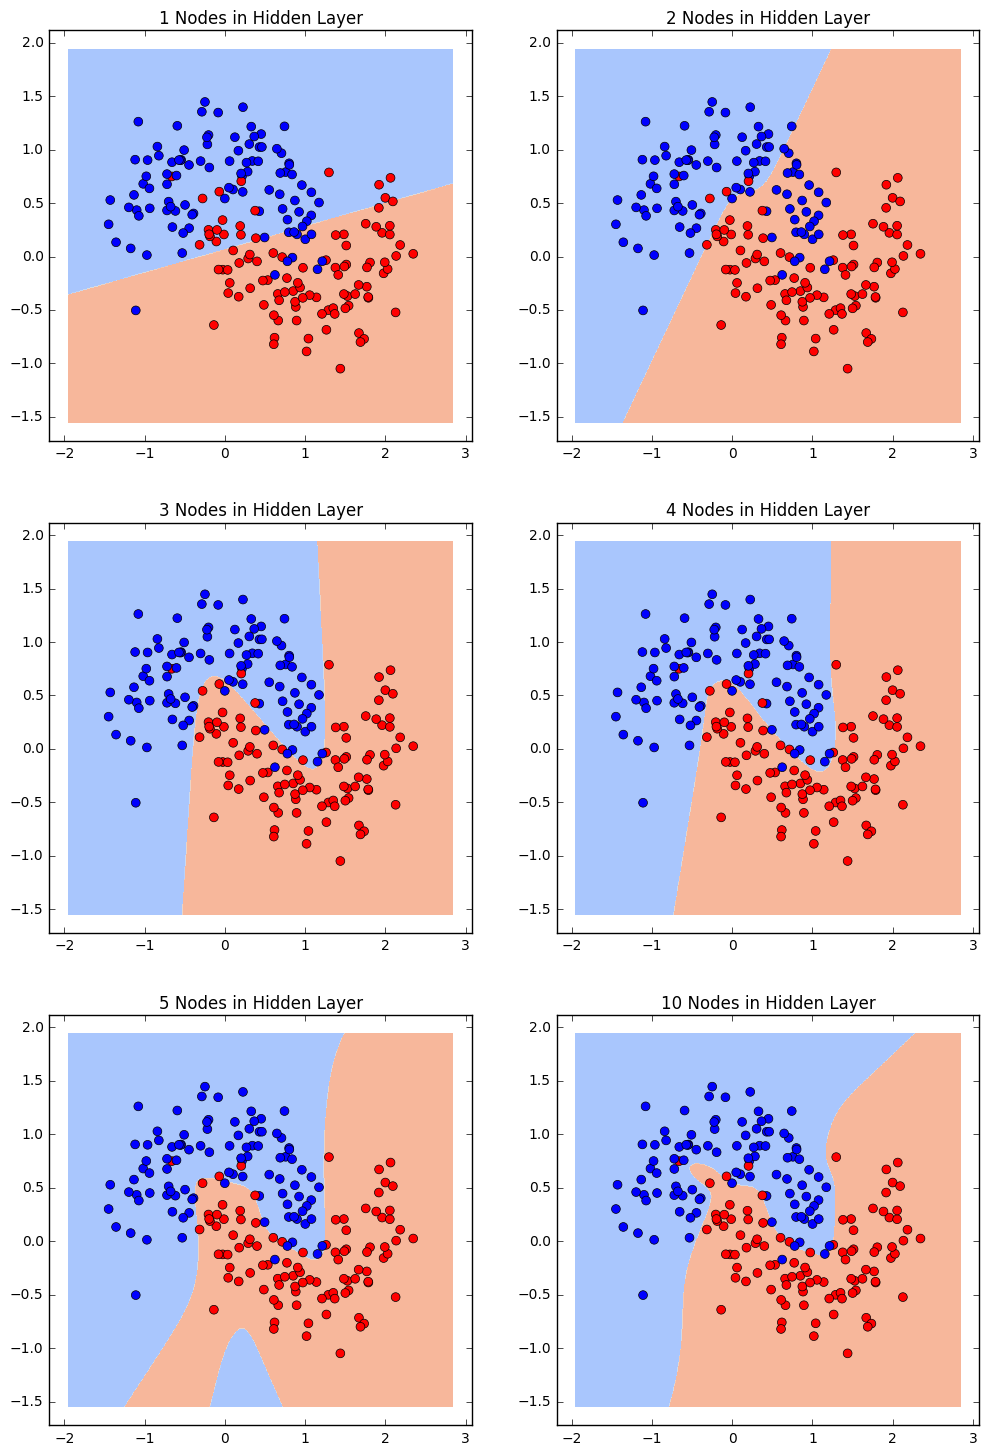

In [12]:
plt.figure(figsize=(12, 18))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 10]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(3, 2, i+1)
    plt.title('%d Nodes in Hidden Layer' % nn_hdim)
    model = train_model(nn_hdim, reg_lambda=reg_param)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()